In [12]:
import sys
sys.path.append('..')
from diffusion4trajectory import diffusion4trajectory, DiffusionConfig
checkpoint = "/cephfs/zhanjh/diffusion4trajectory/checkpoint-21000"

In [ ]:
config = DiffusionConfig.from_pretrained(checkpoint)
diffusion = diffusion4trajectory.from_pretrained(checkpoint, config=config)

loading configuration file /cephfs/zhanjh/diffusion4trajectory/checkpoint-21000/config.json
Model config DiffusionConfig {
  "activation_function": "gelu_new",
  "add_regression_loss": false,
  "architectures": [
    "diffusion4trajectory"
  ],
  "arf_x_random_walk": 0.0,
  "arf_y_random_walk": 0.0,
  "attention_dropout": 0.0,
  "augment_current_pose_rate": 0.0,
  "augment_current_ratio": 0.3,
  "augment_current_with_future_linear_changes": false,
  "augment_current_with_past_linear_changes": false,
  "augment_index": 5,
  "autoregressive": false,
  "autoregressive_proposals": false,
  "backbone_path": null,
  "beta_schedule": "sigmoid",
  "camera_image_encoder": null,
  "cond_dim": 256,
  "current_frame_only": false,
  "d_embed": 256,
  "d_inner": 1024,
  "d_model": 256,
  "ddim": false,
  "debug_raster_path": null,
  "dense_pred": false,
  "diffusion_condition_sequence_lenth": 1,
  "diffusion_feature_save_dir": null,
  "diffusion_timesteps": 100,
  "encoder_type": "raster",
  "finetu

In [ ]:
import os
import pickle
root = '/cephfs/shared/nuplan/online_s6/index'
all_maps_dic = {}
map_folder = os.path.join(root[:-6], 'map')
for each_map in os.listdir(map_folder):
    if each_map.endswith('.pkl'):
        map_path = os.path.join(map_folder, each_map)
        with open(map_path, 'rb') as f:
            map_dic = pickle.load(f)
        map_name = each_map.split('.')[0]
        all_maps_dic[map_name] = map_dic

In [ ]:
import sys
sys.path.append("/cephfs/zhanjh/DiffusionForcing/StateTransformer")
from runner import load_dataset
val_dataset = load_dataset("/cephfs/zhanjh/DiffusionForcing/StateTransformer/data", "finetune", debug = True)

/root/miniconda3/envs/str/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-25 17:10:12.758958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 17:10:12.889128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-25 17:10:12.889165: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp6dnc1in6/cephfs/zhanjh/DiffusionForcing/StateTransformer/data/finetune/unknown/state.json'

: 

In [ ]:
from dataloader.nuplan_raster import nuplan_rasterize_collate_func_raw
data = nuplan_rasterize_collate_func_raw(
    [val_dataset[4]],
    all_maps_dic=all_maps_dic,
    dic_path=root[:-6],
)

In [ ]:
data["raw_trajectory_label"].shape

torch.Size([1, 100, 7])

In [ ]:
trajectory = data["raw_trajectory_label"].clone()

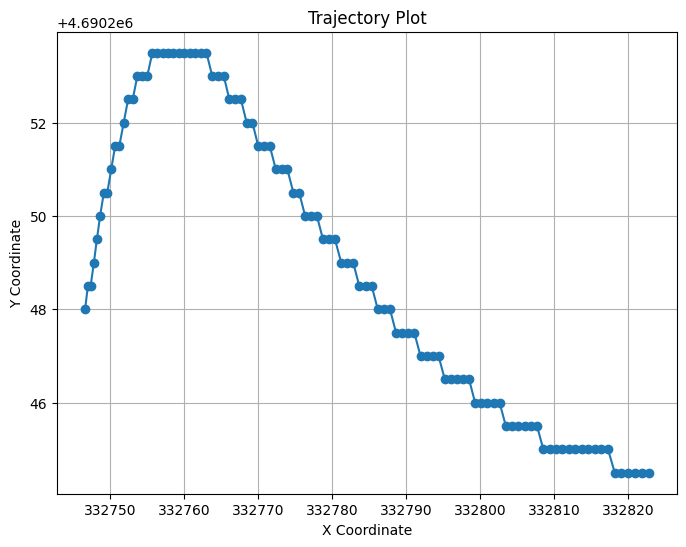

In [ ]:
from utils import plot_trajectory
plot_trajectory(trajectory)

In [ ]:
moving_point = trajectory[0][19]
import torch 
torch.set_printoptions(precision=10, sci_mode=False)
print(moving_point)

tensor([332757.0937500000, 4690253.5000000000,     0.0000000000,     0.0710967928,
            7.2743897438,     3.2548606396,     0.4076006711])


In [ ]:
data["trajectory_label"][0,19]

tensor([15.2589130402, -2.9742596149,  0.0000000000, -0.2690309882])

In [ ]:
import copy
inputs = copy.deepcopy(data)
pred_traj = diffusion.generate(data=inputs)

In [ ]:
pred_logits = pred_traj["traj_logits"]

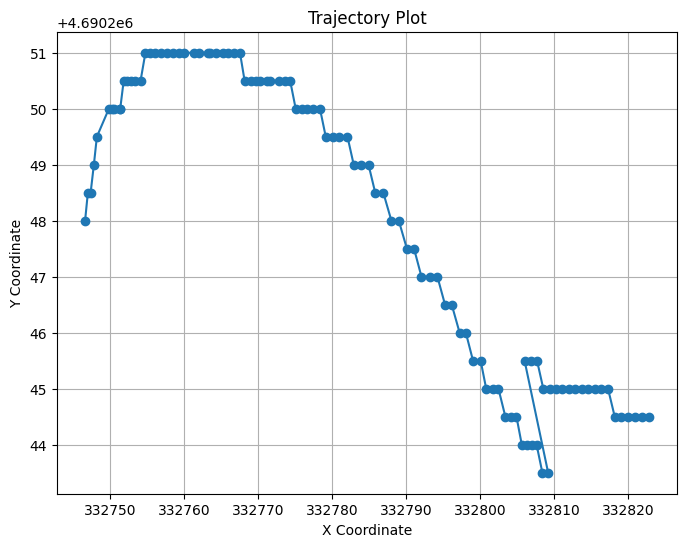

In [ ]:
plot_trajectory(pred_logits)

In [ ]:
mask = torch.ones(1,100,7)
mask[:,:5] = 0
mask[:,-20:] = 0 
mask[:,19] = 0
data["raw_trajectory_label"][0,19,:2] =torch.tensor([332757.0937500000, 4690250.5000000000])

In [ ]:
data["raw_trajectory_label"]

tensor([[[332746.5937500000, 4690248.0000000000,      0.0000000000,
               0.8541612625,      5.6874518394,      2.0945470333,
               0.2999276221],
         [332746.9687500000, 4690248.5000000000,      0.0000000000,
               0.8229036331,      5.7888488770,      2.0802576542,
               0.2965140939],
         [332747.3437500000, 4690248.5000000000,      0.0000000000,
               0.7925337553,      5.8856897354,      1.9504933357,
               0.3096362650],
         [332747.7812500000, 4690249.0000000000,      0.0000000000,
               0.7603518963,      5.9736742973,      1.8894846439,
               0.3491723835],
         [332748.1875000000, 4690249.5000000000,      0.0000000000,
               0.7247889638,      6.0654997826,      2.0471930504,
               0.3930269480],
         [332748.6250000000, 4690250.0000000000,      0.0000000000,
               0.6857163310,      6.1661338806,      3.1716027260,
               0.4075002074],
         [

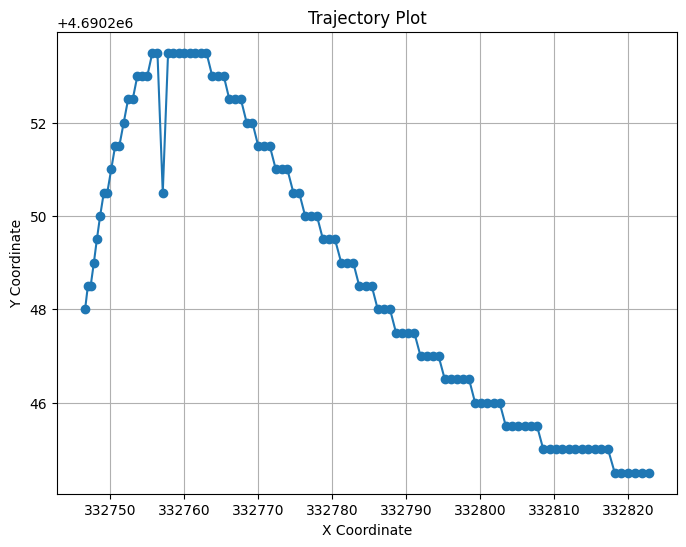

In [ ]:
plot_trajectory(data["raw_trajectory_label"])


In [ ]:
data["mask"] = mask
inputs = data
moving_trajectory = diffusion.generate(data=inputs)["traj_logits"]

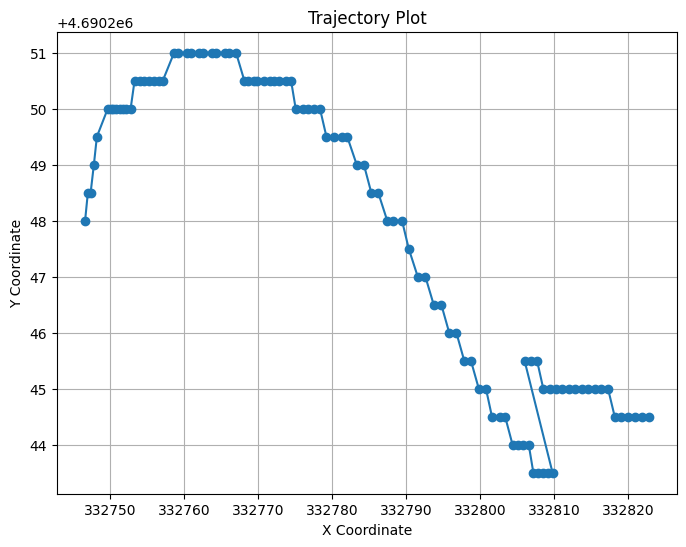

In [ ]:
plot_trajectory(moving_trajectory)


In [ ]:
import pyarrow.ipc as ipc
import pyarrow as pa

# 读取Arrow IPC文件
def read_arrow_file(file_path):
    with pa.OSFile(file_path, 'rb') as source:
        reader = ipc.open_file(source)
        table = reader.read_all()
    return table

# 使用示例
file_path = '/cephfs/zhanjh/DiffusionForcing/StateTransformer/data/val_augmented.arrow'
table = read_arrow_file(file_path)
print(table)


pyarrow.Table
route_ids: list<item: int64>
  child 0, item: int64
road_ids: list<item: int64>
  child 0, item: int64
traffic_ids: list<item: int64>
  child 0, item: int64
traffic_status: list<item: int64>
  child 0, item: int64
agent_ids: list<item: list<item: string>>
  child 0, item: list<item: string>
      child 0, item: string
frame_id: int64
file_name: string
map: string
timestamp: int64
scenario_type: string
t0_frame_id: int64
scenario_id: string
intentions: list<item: int64>
  child 0, item: int64
ego_goal: list<item: float>
  child 0, item: float
navigation: list<item: int64>
  child 0, item: int64
split: string
augmented_trajectory: list<item: float>
  child 0, item: float
----
route_ids: [[[49143,48815,49782,49183,48719,...,49480,48705,48970,49752,48976],[49143,48815,49782,49183,48719,...,49480,48705,48970,49752,48976]]]
road_ids: [[[46863,47028,47029,47146,47147,...,53521,53541,53559,53560,53561],[46863,47028,47029,47146,47147,...,53537,53541,53559,53560,53561]]]
traffic_id

In [ ]:
import pandas as pd

# 将pyarrow.Table转换为Pandas DataFrame
df = table.to_pandas()
print(df)

                                           route_ids  \
0  [49143, 48815, 49782, 49183, 48719, 49464, 508...   
1  [49143, 48815, 49782, 49183, 48719, 49464, 508...   

                                            road_ids traffic_ids  \
0  [46863, 47028, 47029, 47146, 47147, 47175, 471...          []   
1  [46863, 47028, 47029, 47146, 47147, 47175, 471...          []   

  traffic_status                                          agent_ids  frame_id  \
0             []  [[f117d6b9790d5e87], [33f51b8c29fe5dbe], [02fe...      1418   
1             []  [[60f20e5e985156f3], [33f51b8c29fe5dbe], [02fe...      1438   

                                file_name           map         timestamp  \
0  2021.08.31.14.40.58_veh-40_01022_01255  us-ma-boston  1630422084150194   
1  2021.08.31.14.40.58_veh-40_01022_01255  us-ma-boston  1630422085150004   

         scenario_type  t0_frame_id       scenario_id intentions  \
0  starting_right_turn         1378  13441d74ef3d5d25        [1]   
1  starting_ri

In [1]:
from load_augmented import load_dataset
dataset = load_dataset("/cephfs/zhanjh/DiffusionForcing/StateTransformer/data")

/root/miniconda3/envs/str/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pickle
root = '/cephfs/shared/nuplan/online_s6/index'
all_maps_dic = {}
map_folder = os.path.join(root[:-6], 'map')
for each_map in os.listdir(map_folder):
    if each_map.endswith('.pkl'):
        map_path = os.path.join(map_folder, each_map)
        with open(map_path, 'rb') as f:
            map_dic = pickle.load(f)
        map_name = each_map.split('.')[0]
        all_maps_dic[map_name] = map_dic

In [3]:
import sys
sys.path.append("/cephfs/zhanjh/DiffusionForcing/StateTransformer")
from dataloader.nuplan_raster import nuplan_rasterize_collate_func_diffusion

In [4]:
import sys
sys.path.append("/cephfs/zhanjh/DiffusionForcing/StateTransformer")
from dataloader.nuplan_raster import nuplan_rasterize_collate_func_raw

In [17]:
output = nuplan_rasterize_collate_func_diffusion(
    [dataset[3]],
    all_maps_dic=all_maps_dic,
    dic_path=root[:-6],
)

gap:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.68750000e-01  0.00000000e+00 -3.25292349e-05 -2.49801204e-02]
 [ 3.12500000e-01  0.00000000e+00 -2.73380429e-05 -1.94463134e-02]
 [ 2.50000000e-01 -5.00000000e-01 -2.43773684e-05 -1.78821906e-02]
 [ 2.18750000e-01  0.00000000e+00 -2.11261213e-05 -1.52973011e-02]
 [ 1.56250000e-01  0.00000000e+00 -1.94218010e-05 -1.33422241e-02]
 [ 9.37500000e-02  0.00000000e+00 -2.36993656e-05 -1.02863088e-02]
 [ 1.87500000e-01  0.00000000e+00 -1.80541538e-05 -9.43500549e-03]
 [ 1.25000000e-01 -5.00000000e-01 -2.00737268e-05 -8.46488774e-03]
 [ 9.37500000e-02  0.00000000e+00 -2.08406709e-05 -6.27453625e-03]
 [ 2.18750000e-01  0.00000000e+00 -2.05477700e-05 -2.911

In [18]:
from transformer4planning.trainer import save_raster

In [19]:
save_raster(output, sample_index=0,high_scale=3, file_index=0,path_to_save="/cephfs/zhanjh/DiffusionForcing/StateTransformer/diffusion4trajectory/tmp")

length of action and labels:  torch.Size([4, 7])
debug images saved to:  /cephfs/zhanjh/DiffusionForcing/StateTransformer/diffusion4trajectory/tmp 0


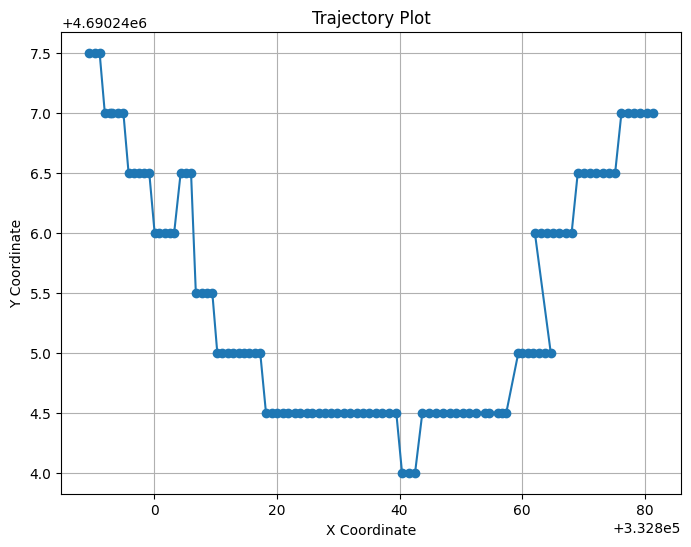

In [20]:
from utils import plot_trajectory
import torch
traj = torch.tensor(dataset[10]["augmented_trajectory"]).unsqueeze(0)
plot_trajectory(traj)